In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
import random
from sklearn.preprocessing import StandardScaler

# =========================
# 1. Load & Utility
# =========================
def load_adbench_data(dataset_path):
    """
    Giả sử file .npz có 'X' và 'y'
    X: (N, d), y: (N,)
    """
    data = np.load(dataset_path)
    X = data['X']
    y = data['y']
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()  # (B,)
            all_preds.append(y_pred.cpu())
            all_labels.append(y_batch.cpu())

    preds = torch.cat(all_preds).numpy()      # (N_test,)
    labels = torch.cat(all_labels).numpy()    # (N_test,)

    # Chuyển sang nhãn nhị phân
    binary_preds = (preds > threshold).astype(int)

    report = classification_report(labels, binary_preds, target_names=['Class 0', 'Class 1'])
    print(report)

    if len(set(labels)) > 1:
        aucroc = roc_auc_score(labels, preds)
        print(f"AUC-ROC: {aucroc:.4f}")
    else:
        aucroc = None
        print("AUC-ROC: Undefined (only one class present in labels)")
    return report, aucroc

# =========================
# 2. Beta-CVAE
# =========================
class BetaCVAE(nn.Module):
    """
    Beta-CVAE cho bài toán nhị phân:
      - Encoder nhận (x, y)
      - Decoder nhận (z, y)
      - Thêm hệ số beta > 1 cho KL-divergence để khuyến khích latent space 'trải rộng'.
    """
    def __init__(self, input_dim, hidden_dim=128, latent_dim=64, beta=4.0):
        super(BetaCVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.beta = beta  # hệ số "phóng đại" KL

        # Encoder
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)   # concat y -> +1
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)      # Thêm một hidden layer
        self.fc3_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc3_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc4 = nn.Linear(latent_dim + 1, hidden_dim)  # concat y -> +1
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)      # Thêm một hidden layer
        self.fc6 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y):
        xy = torch.cat([x, y], dim=1)  # (B, input_dim+1)
        h = F.relu(self.fc1(xy))
        h = F.relu(self.fc2(h))  # Thêm lớp ẩn
        mean = self.fc3_mean(h)
        logvar = self.fc3_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)  # (B, latent_dim+1)
        h = F.relu(self.fc4(zy))
        h = F.relu(self.fc5(h))  # Thêm lớp ẩn
        x_recon = self.fc6(h)
        return x_recon

    def forward(self, x, y):
        mean, logvar = self.encode(x, y)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mean, logvar

def beta_cvae_loss_fn(x, x_recon, mean, logvar, beta=4.0):
    """
    Reconstruction (MSE) + beta * KL-div
    """
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_loss    = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

def train_beta_cvae(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)  # (B,1)
        
        x_recon, mean, logvar = model(x_batch, y_batch)
        loss = beta_cvae_loss_fn(x_batch, x_recon, mean, logvar, beta=model.beta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


# =========================
# 3. Transformer Detector
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        L = x.size(1)
        return x + self.pe[:, :L, :].to(x.device)

class TransformerDetector(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerDetector, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward, 
                                                   dropout=dropout,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze(1)

def train_detector(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)  # (B,)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def log_to_file(file_path, message):
    """
    Ghi message vào file log cụ thể.
    """
    with open(file_path, "a") as file:
        file.write(message + "\n")

def One_Step_To_Feasible_Action(
    beta_cvae, 
    detector, 
    x_orig, 
    device,
    previously_generated=None, 
    alpha=1.0, 
    lambda_div=0.1,
    lr=0.001, 
    steps=50,
    log_file=None
):
    beta_cvae.eval()
    detector.eval()
    if previously_generated is None:
        previously_generated = []

    x_orig = x_orig.to(device).unsqueeze(0)
    y_class1 = torch.full((1, 1), 0.8, device=device)
    with torch.no_grad():
        mean, logvar = beta_cvae.encode(x_orig, y_class1)
        z = beta_cvae.reparameterize(mean, logvar).detach().clone()
    # z = (torch.rand(1, beta_cvae.latent_dim) * 4.0) - 2.0
    # z = z.to(device).requires_grad_(True)
    
    
    optimizer_z = torch.optim.Adam([z], lr=lr)
    for step in range(steps):
        optimizer_z.zero_grad()
        x_synthetic = beta_cvae.decode(z, y_class1)
        prob_class1 = detector(x_synthetic)
        if previously_generated :  # chỉ tính nếu không rỗng
            # 1) Gộp lại thành tensor (N, d)
            x_old_cat = torch.stack(previously_generated, dim=0).to(device)  # (N, d)
        
            # 2) Tính norm theo batch
            # Cách 1: Sử dụng broadcast (x_synthetic - x_old_cat)
            # dist shape (N,)
            dist = torch.norm(x_synthetic - x_old_cat, p=2, dim=1)
            
            # 3) Tính sum của exp(-alpha * dist)
            diversity_term = torch.exp(-alpha * dist).sum()
        
        else:
            diversity_term = 0.0

        loss = prob_class1.mean() + lambda_div * diversity_term
        loss.backward()
        optimizer_z.step()
    

    if log_file:
        log_to_file(log_file, f"Step {step + 1}/{steps}:")
        log_to_file(log_file, f"  Prob_class1: {prob_class1.item():.4f}")
        log_to_file(log_file, f"  Diversity term: {diversity_term:.4f}")
        log_to_file(log_file, f"  Total loss: {loss.item():.4f}")
    print(f"  Prob_class1: {prob_class1.item():.4f}", 
          f"  Diversity term: {diversity_term:.4f}", 
          f"  Total loss: {loss.item():.4f}")
    with torch.no_grad():
        x_adv = beta_cvae.decode(z, y_class1).detach().cpu().squeeze(0)
        # print(x_adv)
    # previously_generated.append(x_adv)
    return x_adv






In [13]:
# Ví dụ đường dẫn
dataset_path = r"D:\Study\Code\SwiftHydra\Classical\1_ALOI.npz"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4.1: Load Data
X_all, y_all = load_adbench_data(dataset_path)
input_dim = X_all.shape[1]

scaler = StandardScaler()
X_all = torch.tensor(scaler.fit_transform(X_all)).float()

# Chia train/test
D_train_np, D_test_np, y_train_np, y_test_np = train_test_split(
    X_all.numpy(), y_all.numpy(), test_size=0.6, random_state=42, stratify=y_all
)
D_train = torch.tensor(D_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
D_test  = torch.tensor(D_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)

# DataLoader cho Beta-CVAE
train_dataset = TensorDataset(D_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)



In [14]:
# 4.2: Khởi tạo Beta-CVAE
# Tăng beta (vd=4.0) để nhấn mạnh KL -> latent space "trải rộng" hơn
beta_cvae = BetaCVAE(input_dim=input_dim, hidden_dim=512, latent_dim=64, beta=1.0).to(device)


In [15]:
  # Train Beta-CVAE
optimizer_cvae = Adam(beta_cvae.parameters(), lr=1e-4)
num_epochs_cvae = 450
for epoch in range(num_epochs_cvae):
    loss_cvae = train_beta_cvae(beta_cvae, train_loader, optimizer_cvae, device)
    if (epoch + 1) % 2 == 0:
        print(f"[Beta-CVAE] Epoch {epoch+1}/{num_epochs_cvae}, loss={loss_cvae:.2f}")


[Beta-CVAE] Epoch 2/450, loss=1504.30
[Beta-CVAE] Epoch 4/450, loss=1128.46
[Beta-CVAE] Epoch 6/450, loss=960.72
[Beta-CVAE] Epoch 8/450, loss=844.77
[Beta-CVAE] Epoch 10/450, loss=765.15
[Beta-CVAE] Epoch 12/450, loss=745.24
[Beta-CVAE] Epoch 14/450, loss=720.34
[Beta-CVAE] Epoch 16/450, loss=715.03
[Beta-CVAE] Epoch 18/450, loss=703.00
[Beta-CVAE] Epoch 20/450, loss=659.90
[Beta-CVAE] Epoch 22/450, loss=649.54
[Beta-CVAE] Epoch 24/450, loss=1120.59
[Beta-CVAE] Epoch 26/450, loss=631.44
[Beta-CVAE] Epoch 28/450, loss=622.59
[Beta-CVAE] Epoch 30/450, loss=626.58
[Beta-CVAE] Epoch 32/450, loss=658.42
[Beta-CVAE] Epoch 34/450, loss=603.07
[Beta-CVAE] Epoch 36/450, loss=593.29
[Beta-CVAE] Epoch 38/450, loss=733.96
[Beta-CVAE] Epoch 40/450, loss=8288.42
[Beta-CVAE] Epoch 42/450, loss=587.72
[Beta-CVAE] Epoch 44/450, loss=872.18
[Beta-CVAE] Epoch 46/450, loss=596.58
[Beta-CVAE] Epoch 48/450, loss=146255.32
[Beta-CVAE] Epoch 50/450, loss=580.87
[Beta-CVAE] Epoch 52/450, loss=564.24
[Beta-CVA

In [16]:
# 4.3: Sinh dữ liệu - maximize diversity
"""
Thay vì z ~ Normal(0,1), ta thử z ~ Uniform([-2,2]) => 
tăng coverage, khuyến khích dữ liệu sinh ra đa dạng hơn
"""
beta_cvae.eval()

minority_mask = (y_train == 1)
X_minority = D_train[minority_mask]
majority_mask = (y_train == 0)
X_majority = D_train[majority_mask]
    
num_generate = len(X_majority) - len(X_minority)  # Hoặc tuỳ ý # số lượng sample sinh ra
with torch.no_grad():
    # Tạo z uniform trong [-2,2]
    z_uniform = (torch.rand(num_generate, beta_cvae.latent_dim) * 4.0) - 2.0
    z_uniform = z_uniform.to(device)
    # Gán y=1 => oversample minority
    # hoặc y=0.7 => “lai”
    # Ở đây ta ví dụ oversample minority
    y_synthetic_c = torch.full((num_generate, 1), 0.9, device=device)

    # Decode
    X_synthetic = beta_cvae.decode(z_uniform, y_synthetic_c)
    X_synthetic = X_synthetic.cpu()
    
    # print(X_synthetic)

# Tạo label = 1 cho samples synthetic
y_synthetic_labels = torch.ones(num_generate)

# Ghép lại
D_train_final = torch.cat([D_train, X_synthetic], dim=0)
y_train_final = torch.cat([y_train, y_synthetic_labels], dim=0)



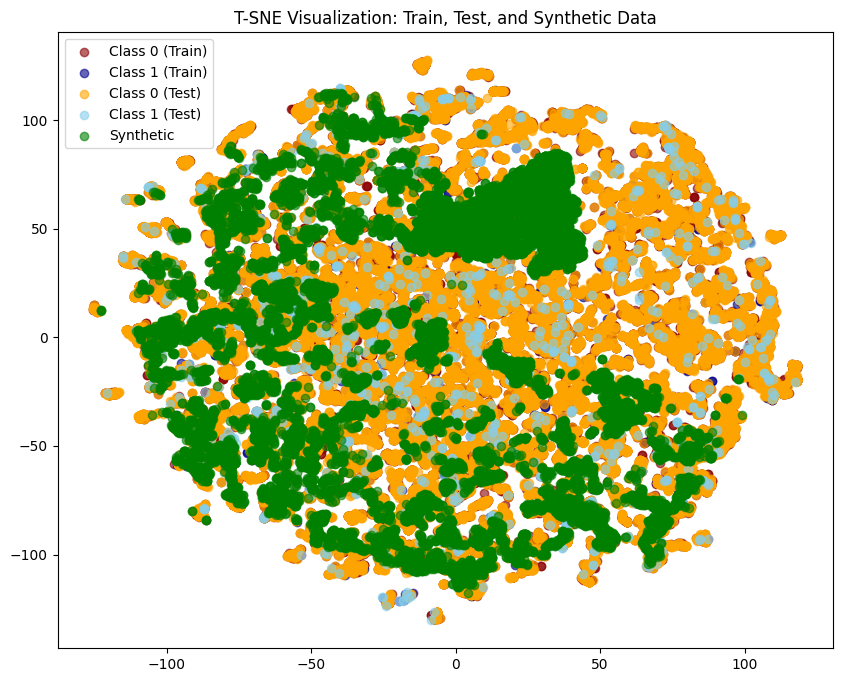

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

plt.style.use('default')  # Đảm bảo sử dụng style mặc định

# Giả sử bạn đã có:
# - D_train, y_train: Dữ liệu train và nhãn
# - D_test, y_test: Dữ liệu test và nhãn
# - X_synthetic: Dữ liệu synthetic

# 1) Gộp dữ liệu
X_plot = torch.cat([D_train, D_test, X_synthetic], dim=0).numpy()

# print(X_synthetic.shape)


# Tạo nhãn:
# - Phần đầu: y_train (0 hoặc 1)
# - Tiếp theo: y_test (0 hoặc 1)
# - Cuối cùng: synthetic (2)
N_train = len(D_train)
N_test = len(D_test)
N_synthetic = len(X_synthetic)
y_plot = np.concatenate([
    y_train.numpy(),            # Nhãn train
    y_test.numpy(),             # Nhãn test
    np.full((N_synthetic,), 2)  # Nhãn synthetic
], axis=0)

# 2) Chuẩn hoá dữ liệu (nếu cần)
scaler = StandardScaler()
X_plot_scaled = scaler.fit_transform(X_plot)

# 3) Tính T-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_embedded = tsne.fit_transform(X_plot_scaled)
# X_embedded.shape = (N_train + N_test + N_synthetic, 2)

# 4) Vẽ
plt.figure(figsize=(10, 8), facecolor='white')  # Đặt nền trắng

# Train Class 0 -> đỏ
idx0_train = (y_plot[:N_train] == 0)
plt.scatter(X_embedded[:N_train][idx0_train, 0], X_embedded[:N_train][idx0_train, 1],
            c='darkred', alpha=0.6, label='Class 0 (Train)')

# Train Class 1 -> xanh dương
idx1_train = (y_plot[:N_train] == 1)
plt.scatter(X_embedded[:N_train][idx1_train, 0], X_embedded[:N_train][idx1_train, 1],
            c='darkblue', alpha=0.6, label='Class 1 (Train)')

# Test Class 0 -> cam
idx0_test = (y_plot[N_train:N_train + N_test] == 0)
plt.scatter(X_embedded[N_train:N_train + N_test][idx0_test, 0], 
            X_embedded[N_train:N_train + N_test][idx0_test, 1],
            c='orange', alpha=0.6, label='Class 0 (Test)')

# Test Class 1 -> xanh nhạt
idx1_test = (y_plot[N_train:N_train + N_test] == 1)
plt.scatter(X_embedded[N_train:N_train + N_test][idx1_test, 0], 
            X_embedded[N_train:N_train + N_test][idx1_test, 1],
            c='skyblue', alpha=0.6, label='Class 1 (Test)')

# Synthetic Data -> xanh lá
idx_syn = (y_plot[N_train + N_test:] == 2)
plt.scatter(X_embedded[N_train + N_test:][idx_syn, 0], 
            X_embedded[N_train + N_test:][idx_syn, 1],
            c='green', alpha=0.6, label='Synthetic')

plt.title("T-SNE Visualization: Train, Test, and Synthetic Data")
plt.legend()
plt.show()


In [18]:
# 4.4: Train mô hình TransformerDetector
train_dataset_final = TensorDataset(D_train_final, y_train_final)
test_dataset = TensorDataset(D_test, y_test)
train_loader_final = DataLoader(train_dataset_final, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
print("Sau khi oversampling bằng VAE:")
unique, counts = np.unique(y_train_final.numpy(), return_counts=True)
print("Phân phối lớp trong tập train:", dict(zip(unique, counts)))
model = TransformerDetector(input_size=input_dim).to(device)
optimizer_tf = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

Sau khi oversampling bằng VAE:
Phân phối lớp trong tập train: {0.0: 19210, 1.0: 19210}


In [19]:
num_epochs_tf = 100
for epoch in range(num_epochs_tf):
    train_loss = train_detector(model, train_loader_final, optimizer_tf, criterion, device)
    print(f"[Transformer] Epoch {epoch+1}/{num_epochs_tf}, Loss={train_loss:.4f}")

    # Đánh giá
    print("Test set evaluation:")
    evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.5)
    print("-" * 40)

[Transformer] Epoch 1/100, Loss=0.4382
Test set evaluation:
              precision    recall  f1-score   support

     Class 0       0.97      0.90      0.94     28816
     Class 1       0.03      0.11      0.05       905

    accuracy                           0.88     29721
   macro avg       0.50      0.51      0.49     29721
weighted avg       0.94      0.88      0.91     29721

AUC-ROC: 0.5467
----------------------------------------
[Transformer] Epoch 2/100, Loss=0.2852
Test set evaluation:
              precision    recall  f1-score   support

     Class 0       0.97      0.86      0.91     28816
     Class 1       0.04      0.19      0.07       905

    accuracy                           0.84     29721
   macro avg       0.51      0.52      0.49     29721
weighted avg       0.94      0.84      0.88     29721

AUC-ROC: 0.5505
----------------------------------------
[Transformer] Epoch 3/100, Loss=0.2436
Test set evaluation:
              precision    recall  f1-score   suppor

In [20]:
import os

# Đảm bảo thư mục lưu trữ tồn tại
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

# Lưu Beta-CVAE
vae_path = os.path.join(save_dir, "beta_cvae.pth")
detector_path = os.path.join(save_dir, "transformer_detector.pth")


In [21]:

torch.save(beta_cvae.state_dict(), vae_path)
print(f"Beta-CVAE model saved to: {vae_path}")
# Lưu TransformerDetector

torch.save(model.state_dict(), detector_path)
print(f"TransformerDetector model saved to: {detector_path}")


Beta-CVAE model saved to: ./saved_models\beta_cvae.pth
TransformerDetector model saved to: ./saved_models\transformer_detector.pth


In [22]:
# Khởi tạo mô hình cùng cấu hình ban đầu
loaded_beta_cvae = BetaCVAE(input_dim=input_dim, hidden_dim=512, latent_dim=64, beta=1.0).to(device)
loaded_detector_model = TransformerDetector(input_size=input_dim).to(device)

# Load trạng thái mô hình đã lưu
# Chỉ load trọng số
loaded_beta_cvae.load_state_dict(torch.load(vae_path, weights_only=True))
loaded_detector_model.load_state_dict(torch.load(detector_path, weights_only=True))

# Đặt mô hình về chế độ eval (nếu chỉ sử dụng inference)
loaded_beta_cvae.eval()
loaded_detector_model.eval()

print("Models loaded successfully.")


Models loaded successfully.


In [23]:
num_episodes = 100
num_gen_data = 50
batch_size = 128
new_detector = TransformerDetector(input_size=input_dim).to(device)
optimizer_cvae = Adam(beta_cvae.parameters(), lr=1e-4)
optimizer_detector = Adam(new_detector.parameters(), lr=1e-4)
# File log
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
beta_cvae_log = os.path.join(log_dir, "beta_cvae.log")
detector_log = os.path.join(log_dir, "detector.log")
adversarial_log = os.path.join(log_dir, "adversarial_samples.log")
synthetic_data = []
start_idx = 0  # Vị trí bắt đầu ban đầu

In [24]:
for ep in range(num_episodes):
    # Lấy mask cho class 1
    class1_mask = (y_train == 1)  # Boolean tensor: True nếu y_train[i] == 1
    class0_mask = (y_train == 0)  # Boolean tensor: True nếu y_train[i] == 0

    # Đếm số lượng phần tử của mỗi class
    num_class1 = class1_mask.sum().item()
    num_class0 = class0_mask.sum().item()

    # Kiểm tra nếu số lượng class 1 vượt quá class 0, thoát vòng lặp
    if num_class1 > num_class0:
        print(f"Break at Episode {ep + 1}: Class 1 ({num_class1}) exceeds Class 0 ({num_class0}).")
        break
    # Lọc các mẫu thuộc class 1 từ D_train
    # Lọc các mẫu thuộc class 1 từ D_train
    D_train_grow_tensor = D_train[class1_mask]  # Tensor chứa tất cả các mẫu class 1
    # Chuyển mỗi hàng thành một tensor và lưu vào list
    D_train_grow = [row for row in D_train_grow_tensor]
    print(f"===== EPISODE {ep + 1}/{num_episodes} =====")
    
    # Train Beta-CVAE
    train_dataset = TensorDataset(D_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    num_epochs_cvae = 10
    for epoch in range(num_epochs_cvae):
        loss_cvae = train_beta_cvae(loaded_beta_cvae, train_loader, optimizer_cvae, device)
        log_to_file(beta_cvae_log, f"Epoch {epoch + 1}/{num_epochs_cvae}, Loss: {loss_cvae:.4f}")
    
    detector_epochs = 5
    train_dataset_detector = TensorDataset(D_train, y_train)
    train_loader_detector = DataLoader(train_dataset_detector, batch_size=batch_size, shuffle=True)
    for det_epoch in range(detector_epochs):
        detector_loss = train_detector(new_detector, train_loader_detector, optimizer_detector, criterion, device)
            # Giả sử y_train có dạng 0/1
    unique, counts = np.unique(y_train.numpy(), return_counts=True)
    print("Phân phối lớp trong tập train:", dict(zip(unique, counts)))
    # print(f"===== Evaluate in Testing set =====")
    # evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.5)
    # Generate Adversarial Samples
    idx_class1 = (y_train == 1).nonzero(as_tuple=True)[0]
    new_samples, new_labels = [], []
    # Lấy các index từ idx_class1, xử lý wrap-around nếu cần
    end_idx = start_idx + num_gen_data
    indices = idx_class1[start_idx:end_idx]
    
    # Nếu vượt quá độ dài của idx_class1, quay lại từ đầu
    if end_idx > len(idx_class1):
        indices += idx_class1[:end_idx - len(idx_class1)]
    
    # Cập nhật vị trí bắt đầu cho vòng lặp tiếp theo
    start_idx = end_idx % len(idx_class1)
    for syn_data in range(num_gen_data):
        print("===== Generated Data {} =====".format(syn_data))
        random_idx = random.choice(idx_class1)
        x_orig = D_train[random_idx]
        x_adv = One_Step_To_Feasible_Action(
            beta_cvae=loaded_beta_cvae,
            detector=loaded_detector_model,
            x_orig=x_orig,
            device=device,
            previously_generated=D_train_grow,
            alpha=1.0,
            lambda_div=0.1,
            lr=0.01,
            steps=20,
            log_file=adversarial_log,
        )
        new_samples.append(x_adv.unsqueeze(0))
        new_labels.append(torch.tensor([1]))
        synthetic_data.append(x_adv)
    new_samples = torch.cat(new_samples, dim=0)
    new_labels = torch.cat(new_labels, dim=0)
    D_train = torch.cat([D_train, new_samples], dim=0)
    y_train = torch.cat([y_train, new_labels], dim=0)
    

===== EPISODE 1/100 =====
Phân phối lớp trong tập train: {0.0: 19210, 1.0: 603}
===== Generated Data 0 =====
  Prob_class1: 1.0000   Diversity term: 66.0051   Total loss: 7.6005
===== Generated Data 1 =====
  Prob_class1: 1.0000   Diversity term: 101.0907   Total loss: 11.1091
===== Generated Data 2 =====
  Prob_class1: 1.0000   Diversity term: 107.7346   Total loss: 11.7734
===== Generated Data 3 =====
  Prob_class1: 1.0000   Diversity term: 60.4999   Total loss: 7.0500
===== Generated Data 4 =====
  Prob_class1: 1.0000   Diversity term: 20.5277   Total loss: 3.0527
===== Generated Data 5 =====
  Prob_class1: 1.0000   Diversity term: 35.4760   Total loss: 4.5476
===== Generated Data 6 =====
  Prob_class1: 1.0000   Diversity term: 93.8370   Total loss: 10.3837
===== Generated Data 7 =====
  Prob_class1: 1.0000   Diversity term: 108.6324   Total loss: 11.8632
===== Generated Data 8 =====
  Prob_class1: 1.0000   Diversity term: 10.6643   Total loss: 2.0664
===== Generated Data 9 =====
  

In [27]:
  # 4.4: Train mô hình TransformerDetector
train_dataset_final = TensorDataset(D_train, y_train)
test_dataset = TensorDataset(D_test, y_test)
train_loader_final = DataLoader(train_dataset_final, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
print("Sau khi oversampling bằng VAE:")
unique, counts = np.unique(y_train.numpy(), return_counts=True)
print("Phân phối lớp trong tập train:", dict(zip(unique, counts)))
model = TransformerDetector(input_size=input_dim).to(device)
optimizer_tf = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
num_epochs_tf = 100
for epoch in range(num_epochs_tf):
    train_loss = train_detector(model, train_loader_final, optimizer_tf, criterion, device)
    print(f"[Transformer] Epoch {epoch + 1}/{num_epochs_tf}, Loss={train_loss:.4f}")

    # Đánh giá
    print("Test set evaluation:")
    evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.3)
    print("-" * 40)

Sau khi oversampling bằng VAE:
Phân phối lớp trong tập train: {0.0: 19210, 1.0: 603}
[Transformer] Epoch 1/100, Loss=0.1414
Test set evaluation:
              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98     28816
     Class 1       1.00      0.00      0.00       905

    accuracy                           0.97     29721
   macro avg       0.98      0.50      0.49     29721
weighted avg       0.97      0.97      0.95     29721

AUC-ROC: 0.5553
----------------------------------------
[Transformer] Epoch 2/100, Loss=0.1379
Test set evaluation:


C:\Users\Legion 7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Legion 7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Legion 7\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

              precision    recall  f1-score   support

     Class 0       0.97      1.00      0.98     28816
     Class 1       0.00      0.00      0.00       905

    accuracy                           0.97     29721
   macro avg       0.48      0.50      0.49     29721
weighted avg       0.94      0.97      0.95     29721

AUC-ROC: 0.5695
----------------------------------------
[Transformer] Epoch 3/100, Loss=0.1365
Test set evaluation:


KeyboardInterrupt: 

torch.Size([5000, 27])


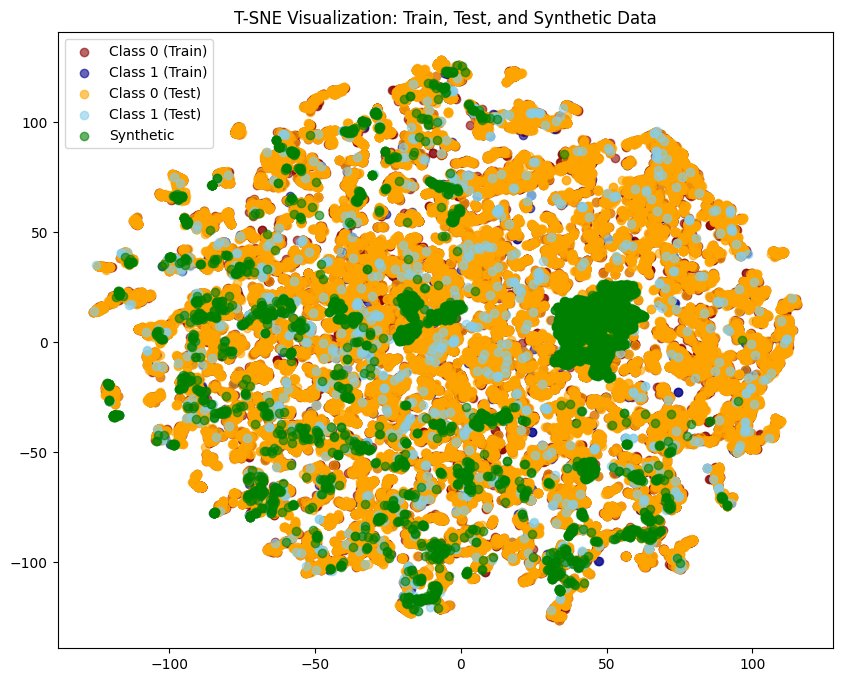

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

plt.style.use('default')  # Đảm bảo sử dụng style mặc định

# Giả sử bạn đã có:
# - D_train, y_train: Dữ liệu train và nhãn
# - D_test, y_test: Dữ liệu test và nhãn
# - X_synthetic: Dữ liệu synthetic
D_train = torch.tensor(D_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
D_test  = torch.tensor(D_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)

X_synthetic = np.asarray(synthetic_data)


X_synthetic = torch.tensor(X_synthetic,  dtype=torch.float32)

print(X_synthetic.shape)

# 1) Gộp dữ liệu
X_plot = torch.cat([D_train, D_test, X_synthetic], dim=0).numpy()

# Tạo nhãn:
# - Phần đầu: y_train (0 hoặc 1)
# - Tiếp theo: y_test (0 hoặc 1)
# - Cuối cùng: synthetic (2)
N_train = len(D_train)
N_test = len(D_test)
N_synthetic = len(X_synthetic)
y_plot = np.concatenate([
    y_train.numpy(),            # Nhãn train
    y_test.numpy(),             # Nhãn test
    np.full((N_synthetic,), 2)  # Nhãn synthetic
], axis=0)

# 2) Chuẩn hoá dữ liệu (nếu cần)
scaler = StandardScaler()
X_plot_scaled = scaler.fit_transform(X_plot)

# 3) Tính T-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_embedded = tsne.fit_transform(X_plot_scaled)
# X_embedded.shape = (N_train + N_test + N_synthetic, 2)

# 4) Vẽ
plt.figure(figsize=(10, 8), facecolor='white')  # Đặt nền trắng

# Train Class 0 -> đỏ
idx0_train = (y_plot[:N_train] == 0)
plt.scatter(X_embedded[:N_train][idx0_train, 0], X_embedded[:N_train][idx0_train, 1],
            c='darkred', alpha=0.6, label='Class 0 (Train)')

# Train Class 1 -> xanh dương
idx1_train = (y_plot[:N_train] == 1)
plt.scatter(X_embedded[:N_train][idx1_train, 0], X_embedded[:N_train][idx1_train, 1],
            c='darkblue', alpha=0.6, label='Class 1 (Train)')

# Test Class 0 -> cam
idx0_test = (y_plot[N_train:N_train + N_test] == 0)
plt.scatter(X_embedded[N_train:N_train + N_test][idx0_test, 0], 
            X_embedded[N_train:N_train + N_test][idx0_test, 1],
            c='orange', alpha=0.6, label='Class 0 (Test)')

# Test Class 1 -> xanh nhạt
idx1_test = (y_plot[N_train:N_train + N_test] == 1)
plt.scatter(X_embedded[N_train:N_train + N_test][idx1_test, 0], 
            X_embedded[N_train:N_train + N_test][idx1_test, 1],
            c='skyblue', alpha=0.6, label='Class 1 (Test)')

# Synthetic Data -> xanh lá
idx_syn = (y_plot[N_train + N_test:] == 2)
plt.scatter(X_embedded[N_train + N_test:][idx_syn, 0], 
            X_embedded[N_train + N_test:][idx_syn, 1],
            c='green', alpha=0.6, label='Synthetic')

plt.title("T-SNE Visualization: Train, Test, and Synthetic Data")
plt.legend()
plt.show()
